# Named Entity Recognition Modeling with Bidirectional LSTM

## Import Packages

In [19]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import pickle

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

## 개체명 인식 데이터 로드

In [4]:
ner_df = pd.read_pickle('./data/ner_df.pickle')
ner_df

,question,intent,tokenized_sample,ner_label
0,AJ네트웍스의 유사 종목,유사기업,"[AJ네트웍스, 의, 유사, 종목]","[B-STK, O, O, O]"
1,AJ네트웍스의 유사 종목 보여줘,유사기업,"[AJ네트웍스, 의, 유사, 종목, 보여줘]","[B-STK, O, O, O, O]"
2,AJ네트웍스의 유사 종목 알려줘,유사기업,"[AJ네트웍스, 의, 유사, 종목, 알려줘]","[B-STK, O, O, O, O]"
3,AJ네트웍스의 유사 종목 열람,유사기업,"[AJ네트웍스, 의, 유사, 종목, 열람]","[B-STK, O, O, O, O]"
4,AJ네트웍스와 유사 종목은 뭐가 있어?,유사기업,"[AJ네트웍스, 와, 유사, 종목, 은, 뭐, 가, 있, 어, ?]","[B-STK, O, O, O, O, O, O, O, O, O]"
...,...,...,...,...
131700,힘스 가격 추이 띄워,가격,"[힘스, 가격, 추이, 띄워]","[B-STK, B-PRI, I-PRI, O]"
131701,힘스 가격 추이 어때?,가격,"[힘스, 가격, 추이, 어때, ?]","[B-STK, B-PRI, I-PRI, O, O]"
131702,힘스 가격 추이 어떻게 돼?,가격,"[힘스, 가격, 추이, 어떻게, 돼, ?]","[B-STK, B-PRI, I-PRI, O, O, O]"
131703,힘스 가격 추이 궁금해,가격,"[힘스, 가격, 추이, 궁금, 해]","[B-STK, B-PRI, I-PRI, O, O]"


### ner_df 데이터 구조 시각화

In [5]:
ner_sentences = ner_df['tokenized_sample'].to_list()
ner_tags = ner_df['ner_label'].to_list()

샘플의 최대 길이 : 13
샘플의 평균 길이 : 5.093379


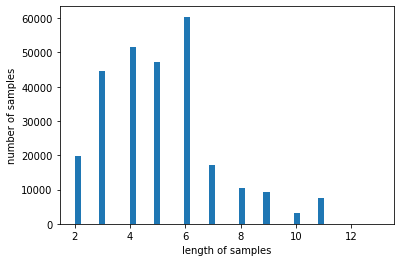

In [6]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in ner_sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, ner_sentences))/len(ner_sentences)))
plt.hist([len(s) for s in ner_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 개체명 인식 데이터 Tokenizing

In [7]:
# 모든 단어를 사용하지만, Index 1에는 'Out of Vocabulary' 할당
src_tokenizer = Tokenizer(oov_token = 'OOV')
src_tokenizer.fit_on_texts(ner_sentences)
# Tagging 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer = Tokenizer(lower = False)
tar_tokenizer.fit_on_texts(ner_tags)

In [8]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기: {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기: {}'.format(tag_size))

단어 집합의 크기: 3227
개체명 태깅 정보 집합의 크기: 8


In [9]:
print('단어 OOV의 인덱스: {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스: 1


In [10]:
X_data = src_tokenizer.texts_to_sequences(ner_sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [11]:
print(X_data[0], y_data[0])

[88, 35, 28, 26] [2, 1, 1, 1]


In [12]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'
index_to_ner

{1: 'O',
 2: 'B-STK',
 3: 'B-PRI',
 4: 'I-PRI',
 5: 'B-KEY',
 6: 'I-KEY',
 7: 'I-STK',
 0: 'PAD'}

In [13]:
decoded = []
for index in X_data[0]:
    decoded.append(index_to_word[index])
    
print('기존의 문장: {}'.format(ner_sentences[0]))
print('디코딩 문장: {}'.format(decoded))

기존의 문장: ['AJ네트웍스', '의', '유사', '종목']
디코딩 문장: ['aj네트웍스', '의', '유사', '종목']


In [14]:
max_len = 12
X_data = pad_sequences(X_data, padding = 'post', maxlen = max_len)
y_data = pad_sequences(y_data, padding = 'post', maxlen = max_len)

### train, test set으로 데이터 분리

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = .2, random_state = 42)

In [16]:
y_train = to_categorical(y_train, num_classes = tag_size)
y_test = to_categorical(y_test, num_classes = tag_size)

In [17]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (217376, 12)
훈련 샘플 레이블의 크기 : (217376, 12, 8)
테스트 샘플 문장의 크기 : (54345, 12)
테스트 샘플 레이블의 크기 : (54345, 12, 8)


## Tokenizer 저장

In [1]:
# %mkdir ./tokenizer
# %ls

LICENSE                                 scrapping
data                                    tokenizer
named_entity_recognition_modeling.ipynb training_data_generate.ipynb


In [20]:
with open('./tokenizer/ner_src_tokenizer.pickle', 'wb') as handle:
    pickle.dump(src_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with open('./tokenizer/ner_tar_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tar_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Modeling

In [22]:
# # M1 mac GPU setting code
# import tensorflow as tf
# tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
# gpus = tf.config.experimental.list_physical_devices('GPU')

# if gpus:
#     # 텐서플로가 첫 번째 GPU만 사용하도록 제한
#     try:
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#     except RuntimeError as e:
#     # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
#         print(e)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [25]:
embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero = True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences = True)))
model.add(TimeDistributed(Dense(tag_size, activation = ('softmax'))))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.001), metrics = ['accuracy'])

history = model.fit(X_train, y_train, batch_size = 128, epochs = 6, validation_split = 0.1)

Metal device set to: Apple M1


2022-03-16 15:36:29.088920: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-16 15:36:29.089302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-16 15:36:30.160439: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/6


2022-03-16 15:36:31.648513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 15:36:32.353060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 15:36:32.514565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 15:36:35.292314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 15:36:35.404175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1529/1529 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9881

2022-03-16 15:40:51.144194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 15:40:51.447474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 15:40:51.494226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1529/1529 [==============================] - 274s 176ms/step - loss: 0.0192 - accuracy: 0.9881 - val_loss: 3.5792e-04 - val_accuracy: 0.9999
Epoch 2/6
1529/1529 [==============================] - 268s 175ms/step - loss: 1.8760e-04 - accuracy: 0.9999 - val_loss: 2.5692e-05 - val_accuracy: 1.0000
Epoch 3/6
1529/1529 [==============================] - 277s 181ms/step - loss: 3.4785e-05 - accuracy: 1.0000 - val_loss: 1.4483e-05 - val_accuracy: 1.0000
Epoch 4/6
1529/1529 [==============================] - 272s 178ms/step - loss: 4.3759e-05 - accuracy: 1.0000 - val_loss: 3.5803e-06 - val_accuracy: 1.0000
Epoch 5/6
1529/1529 [==============================] - 272s 178ms/step - loss: 4.3363e-06 - accuracy: 1.0000 - val_loss: 1.7660e-06 - val_accuracy: 1.0000
Epoch 6/6
1529/1529 [==============================] - 268s 175ms/step - loss: 2.6884e-05 - accuracy: 1.0000 - val_loss: 1.7506e-06 - val_accuracy: 1.0000


In [41]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

ModuleNotFoundError: No module named 'seqeval'

In [ ]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
        result = []
        for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
            tag = []
            for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
                pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
                tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
            result.append(tag)
        return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs={}):

      # char Embedding을 사용하는 경우
        if self.use_char:
            X_test = self.validation_data[0]
            X_char_test = self.validation_data[1]
            y_test = self.validation_data[2]
            y_predicted = self.model.predict([X_test, X_char_test])

        else:
            X_test = self.validation_data[0]
            y_test = self.validation_data[1]
            y_predicted = self.model.predict([X_test])

        pred_tags = self.sequences_to_tags(y_predicted)
        test_tags = self.sequences_to_tags(y_test)

        score = f1_score(pred_tags, test_tags)
        print(' - f1: {:04.2f}'.format(score * 100))
        print(classification_report(test_tags, pred_tags))

      # F1-score가 지금까지 중 가장 높은 경우
        if score > self.value:
            print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
            self.model.save('ner_crf_best_model.h5')
            self.value = score
        else:
            print('f1_score did not improve from %f'%(self.value))